## Importing required modules

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, pairwise_distances


## Experiments ran with XGBoost Regressor
<br>

#### This notebook contains the following tests conducted using different parameters for the XGBoost algorithm:
####1. A comprehensive analysis was performed with various max_depth values, and an elbow curve was plotted to evaluate the model's performance.
####2. Performing grid search cross-validation to optimize the XGBoost hyperparameters, including max_depth, learning_rate, and min_child_weight.


In [ ]:
import pandas as pd

def save_test_predictions_in_kaggle_format(array, experiment=None, save=False):
    # Create a DataFrame with "Id" and "Predicted" columns
    df = pd.DataFrame({'Id': range(len(array)), 'Predicted': array})

    if save:
        assert experiment is not None, "Please provide an experiment name."
        # Save the DataFrame to a CSV file
        df.to_csv(f"{experiment}-submission.csv", index=False)

    return df

## Loading the cleaned dataset

### Loading the dataset from drive

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

train_df = pd.read_csv("/content/drive/MyDrive/train_clean.csv")
X_test = pd.read_csv("/content/drive/MyDrive/test_clean.csv")

Mounted at /content/drive


### Run the below cell if you want to load the dataset locally

In [ ]:
datasets_path = "../../datasets/final"
train_path = f"{datasets_path}/train_clean.csv"
test_path = f"{datasets_path}/test_clean.csv"

#load dataframe
train_df = pd.read_csv(train_path)
X_test = pd.read_csv(test_path)

In [ ]:
y = train_df['monthly_rent']
X = train_df.drop(columns=['monthly_rent'])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,rent_approval_date,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,distance_to_nearest_existing_mrt,distance_to_nearest_planned_mrt,distance_to_nearest_school,distance_to_nearest_mall,...,town_pasir ris,town_punggol,town_queenstown,town_sembawang,town_sengkang,town_serangoon,town_tampines,town_toa payoh,town_woodlands,town_yishun
49578,0.866081,0.50,0.397790,0.603774,1.308722,103.796751,0.147207,0.326400,0.507243,0.097611,...,False,False,True,False,False,False,False,False,False,False
50763,0.767289,0.75,0.563536,0.339623,1.346522,103.734843,0.201964,0.068745,0.346423,0.682251,...,False,False,False,False,False,False,False,False,False,False
24147,0.933041,0.75,0.491713,0.490566,1.367566,103.951903,0.260956,0.060712,0.028869,0.249039,...,True,False,False,False,False,False,False,False,False,False
13290,0.599341,0.25,0.215470,0.396226,1.363576,103.745977,0.336514,0.071959,0.145460,0.647535,...,False,False,False,False,False,False,False,False,False,False
17890,0.198683,0.75,0.558011,0.547170,1.346176,103.757834,0.385762,0.162398,0.062420,0.461309,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
y_train.head()

49578    4000
50763    4000
24147    3550
13290    2750
17890    2000
Name: monthly_rent, dtype: int64

In [ ]:
len(X_test)

30000

##### During the initial analysis, I utilized the elbow curve method to determine the optimal maximum depth for the tree-based model.Consequently, I did further analysis by utilizing other techniques such as grid search to effectively evaluate the model's performance and fine-tune the parameters.

## XGBoost Regression Model Training and Evaluation with Default Parameters


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define the parameters for the XGBoost Regressor
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10
}

# Train the XGBoost model
num_round = 50
model = xgb.train(params, dtrain, num_round)

# Make predictions on the validation set
y_pred = model.predict(dval)

# Calculate the root mean squared error (RMSE)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 484.9566269788783


## 1. Trying for different values of Max Depth (keeping other parameters constant) and plotting the elbow curve

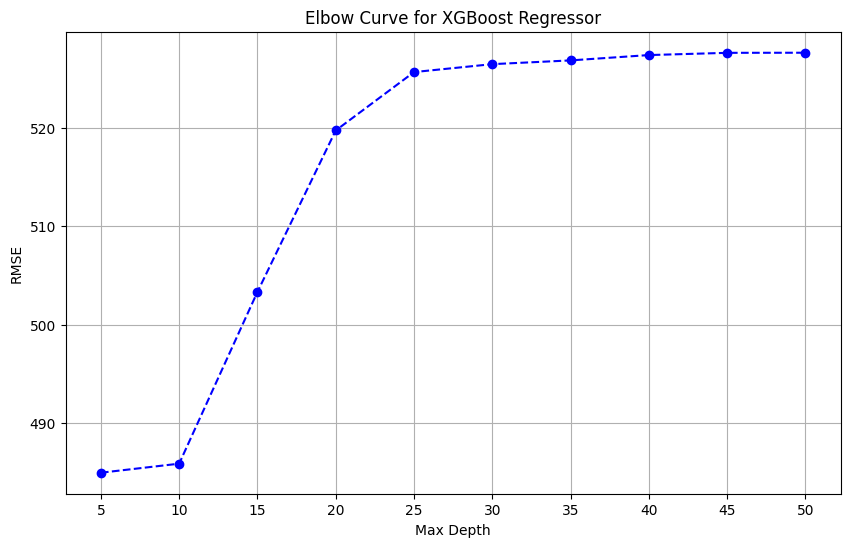



 Least RMSE: 484.9566269788783 with max_depth: 5


In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Define the parameters for the XGBoost Regressor
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,  # Initial value, will be up  dated later
    'alpha': 10
}

# Initialize variables to store the minimum RMSE and corresponding parameters
min_rmse = float('inf')
best_max_depth = 5

# Store RMSE values for each value of max_depth
rms_values_xgb = []  # Collect RMSE values for the plot
for max_depth in range(5, 51, 5):  # Change the range and step size as needed
    params['max_depth'] = max_depth
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Train the XGBoost model
    num_round = 50
    model = xgb.train(params, dtrain, num_round)

    # Make predictions on the validation set
    y_pred = model.predict(dval)

    # Calculate the root mean squared error (RMSE)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    # Update minimum RMSE and corresponding max_depth
    if rmse < min_rmse:
        min_rmse = rmse
        best_max_depth = max_depth

    rms_values_xgb.append(rmse)  # Append the RMSE values for the current max_depth

# Plotting the elbow curve for XGBoost
plt.figure(figsize=(10, 6))
plt.plot(range(5, 51, 5), rms_values_xgb, marker='o', linestyle='--', color='b')
plt.title('Elbow Curve for XGBoost Regressor')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.xticks(range(5, 51, 5))
plt.grid()
plt.show()

# Print the least RMSE and the corresponding best max_depth
print(f"\n\n Least RMSE: {min_rmse} with max_depth: {best_max_depth}")


##2. Grid Search CV Implementation for XGBoost Hyperparameter Tuning

#### Hyperparameters: (max_depth, learning_rate, gamma, subsample, random_state, colsample_bytree)

In [ ]:
import warnings
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the parameters for the Grid Search
param_grid_xgb1 = {
    'max_depth': list(range(0, 12, 1)),
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'random_state': [42],
    'colsample_bytree':[0.3]
}

# Create the XGBoost Regressor with GPU support
xgb_regressor = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)

# Create the GridSearchCV object
grid_search_xgb = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid_xgb1, scoring='neg_mean_squared_error', cv=5, verbose=3)


# Assuming you have X_train, y_train, X_val, and y_val already defined, fit the model to the data
grid_search_xgb.fit(X_train, y_train)

# Get the best estimator (model)
best_xgb_regressor = grid_search_xgb.best_estimator_

# Make predictions on the validation data
y_pred_xgb = best_xgb_regressor.predict(X_val)

# Calculate the root mean squared error (RMSE)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)

# Print the best hyperparameters and RMSE
print("\n\n Finished Grid Search")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_depth=0, random_state=42, subsample=0.8;, score=-291987.917 total time=  26.3s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_depth=0, random_state=42, subsample=0.8;, score=-291236.936 total time=  25.7s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_depth=0, random_state=42, subsample=0.8;, score=-289970.718 total time=  25.7s
[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_depth=0, random_state=42, subsample=0.8;, score=-288815.458 total time=  25.8s
[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_depth=0, random_state=42, subsample=0.8;, score=-305202.646 total time=  25.7s
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_depth=0, random_state=42, subsample=1.0;, score=-292309.058 total time=  30.5s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.

In [ ]:
print(f"Best Hyperparameters: {grid_search_xgb.best_params_}")
print(f"RMSE: {rmse_xgb}")

Best Hyperparameters: {'colsample_bytree': 0.3, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'random_state': 42, 'subsample': 1.0}
RMSE: 480.65605377316126


## Making predictions for the XGBoost Regressor

In [ ]:
y_pred_test = best_xgb_regressor.predict(X_test)

save_test_predictions_in_kaggle_format(y_pred_test, "XGBoost Regressor-2", True)

,Id,Predicted
0,0,3271.387207
1,1,2784.482422
2,2,3526.236816
3,3,1892.888916
4,4,2642.446289
...,...,...
29995,29995,2891.112793
29996,29996,2895.971436
29997,29997,2744.259521
29998,29998,3307.570801
